In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import norm

In [2]:
def download_data(tickers, start_date, end_date):
    """
    Downloads financial data for the given tickers and time range.
    """
    return yf.download(tickers, start=start_date, end=end_date, progress=False)

def calculate_value_change(data, positions):
    """
    Calculates the value change for each instrument based on closing and opening prices.
    """
    changes = data['Close'].sub(data['Open'])
    return changes.multiply(positions, axis='columns')

In [3]:
# final_positions = pd.read_csv('final_position.csv', index_col=0).squeeze("columns")
# example
final_positions = {
    "AAPL": 56,
    "AMD": 20,
    "AMZN": 35,
    "BA": 25,
    "BNZL": 100,
    "DLR": 55,
    "EWZ": 0,
    "GOOG": 41,
    "HYG": 540,
    "LULU": 7,
    "MC": 6,
    "MCO": 28,
    "META": 18,
    "MSFT": 20,
    "NVDA": 10,
    "NVO": 55,
    "SHY": 44,
    "TLT": 56,
    "UNH": 20,
    "V": 44,
}
final_positions = pd.Series(final_positions, name="Quantity")


start_date, end_date = '2023-01-01', '2024-01-01'
# print(type(final_positions))
# print(final_positions)
tickers = final_positions.index.unique().tolist()
tickers = ['BNZL.L' if ticker == 'BNZL' else ticker for ticker in tickers]
tickers = ['MC.PA' if ticker == 'MC' else ticker for ticker in tickers]
final_positions.rename(index={'BNZL': 'BNZL.L'}, inplace=True)
final_positions.rename(index={'MC': 'MC.PA'}, inplace=True)
financial_data = download_data(tickers, start_date, end_date)
value_change = calculate_value_change(financial_data, final_positions)

# Optional: Save the value change DataFrame to CSV
value_change.to_csv('value_change.csv', index=True)

# Calculate and print the sum of rows
row_sums = value_change.sum(axis=1)

In [4]:
def calculate_returns(data):
    """
    Calculates the daily returns for the given data.
    """
    return data.pct_change().dropna()

def calculate_beta(asset_returns, market_returns):
    """
    Calculates the beta value of an asset or portfolio relative to the market.
    """
    covariance = asset_returns.cov(market_returns)
    # print(covariance)
    market_variance = market_returns.var()
    # print(market_variance)
    return covariance / market_variance

def calculate_portfolio_value(financial_data, final_positions):
    """
    Calculates the daily total value of the portfolio.
    """
    # 计算每个资产每天的价值
    daily_values = financial_data['Close'] * final_positions
    # print(daily_values)
    daily_values = daily_values.dropna()
    # 计算投资组合的每日总价值
    total_value = daily_values.sum(axis=1)
    print(total_value)
    return total_value

In [5]:
# Download S&P 500 Index data for the same time range
market_data = download_data(['^GSPC'], start_date, end_date)
market_returns = calculate_returns(market_data['Close'])

# Calculate the portfolio's returns
portfolio_returns = calculate_returns(value_change.sum(axis=1))
portfolio_returns = portfolio_returns[1:]

# 重新计算投资组合的每日总价值和收益率
portfolio_total_value = calculate_portfolio_value(financial_data, final_positions)
portfolio_returns = portfolio_total_value.pct_change().dropna()

Date
2023-01-03    399064.288347
2023-01-04    406268.706480
2023-01-05    405012.275614
2023-01-06    411419.709234
2023-01-09    413465.296520
                  ...      
2023-12-21    471188.319260
2023-12-22    470467.430244
2023-12-27    470534.470543
2023-12-28    470905.301781
2023-12-29    469660.108910
Length: 245, dtype: float64


In [6]:
final_positions.to_csv('final_positions.csv', index=True)

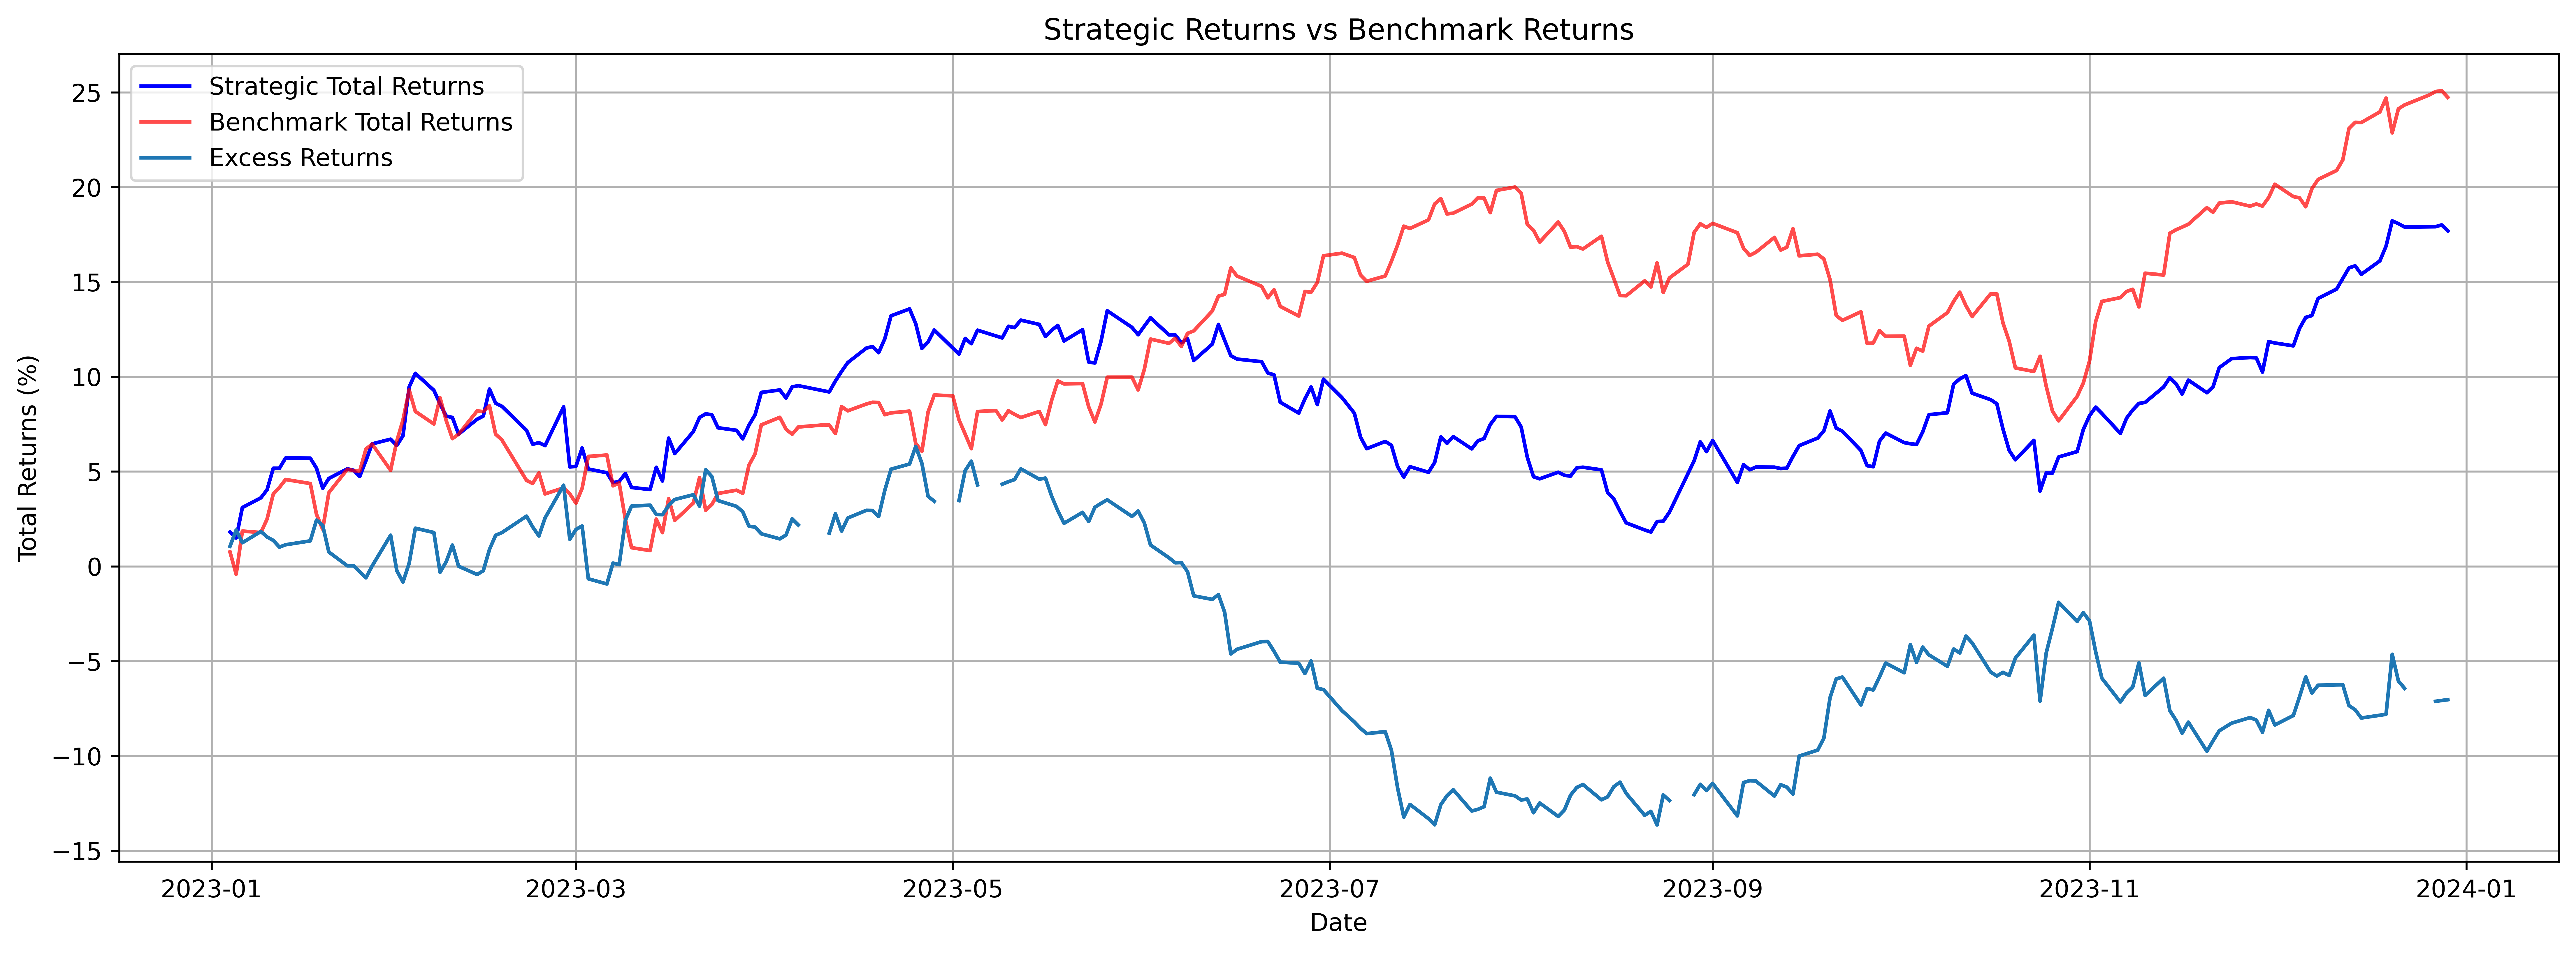

In [7]:
# 计算累积收益
cumulative_returns_portfolio = (1 + portfolio_returns).cumprod()
cumulative_returns_market = (1 + market_returns).cumprod()

# 转换为相对于第一天的百分比变化
cumulative_returns_portfolio_percent = (cumulative_returns_portfolio - 1) * 100
cumulative_returns_market_percent = (cumulative_returns_market - 1) * 100
# 计算超额收益
excess_returns = cumulative_returns_portfolio_percent-cumulative_returns_market_percent

plt.figure(figsize=(18, 6), dpi=600)
plt.plot(cumulative_returns_portfolio_percent.index, cumulative_returns_portfolio_percent, label='Strategic Total Returns', color='blue')
plt.plot(cumulative_returns_market_percent.index, cumulative_returns_market_percent, label='Benchmark Total Returns', alpha=0.7, color='red')
plt.plot(excess_returns.index, excess_returns, label='Excess Returns')
plt.title('Strategic Returns vs Benchmark Returns')
plt.xlabel('Date')
plt.ylabel('Total Returns (%)')
plt.legend()
plt.grid(True)
plt.show()


贝塔值（Beta）是一个衡量投资组合或股票相对于整个市场波动性的指标。
贝塔值的计算公式:

$\beta = \frac{\text{Cov}(r_a, r_m)}{\text{Var}(r_m)}$

贝塔值越大，资产的收益率与市场收益率的相关性越强。

其中：
- $\beta$ 是贝塔值。
- $\text{Cov}(r_a, r_m)$是资产收益率$r_a$和市场收益率$r_m$之间的协方差。
- $\text{Var}(r_m)$ 是市场收益率的方差。

理想值:
- 如果 $\beta = 1$，则表明该资产的价格波动与市场平均水平相同。
- 如果 $\beta > 1$，则表明资产比市场更有波动性（更具风险性）。
- 如果 $\beta < 1$，则表明资产的波动性小于市场。


In [8]:
# 计算贝塔值
portfolio_beta = calculate_beta(portfolio_returns, market_returns)
print("Portfolio Beta:", portfolio_beta)

Portfolio Beta: 0.3847064177182904


**阿尔法的计算公式：**

$text{Alpha} = R_p - (R_f + \beta \times (R_m - R_f))$

其中：

- $R_p$ 是投资组合的实际年化收益率。
- $R_f$ 是无风险收益率。
- $\beta$ 是投资组合相对于基准的贝塔值。
- $R_m$ 是市场基准的年化收益率。

阿尔法值表示投资组合超过（或低于）基于其风险水平所预期的市场回报的程度。正阿尔法值意味着投资表现超过了其贝塔所预测的回报，而负阿尔法值则意味着表现低于预期。


In [9]:
# 假设的年交易日数
annual_trading_days = 252
# 计算平均日收益率
average_daily_return = portfolio_returns.mean()
# 年化收益率
annualized_return = (1 + average_daily_return) ** annual_trading_days - 1
# 计算市场基准的平均日收益率
average_daily_market_return = market_returns.mean()
# 年化市场基准收益率
annualized_market_return = (1 + average_daily_market_return) ** annual_trading_days - 1
# 无风险利率
risk_free_rate = 0.0505  # 根据您之前的描述
# 计算阿尔法
alpha = annualized_return - (risk_free_rate + portfolio_beta * (annualized_market_return - risk_free_rate))
print("投资策略的阿尔法: {:.4f}".format(alpha))

投资策略的阿尔法: 0.0601


In [10]:
# 假设的年交易日数
annual_trading_days = 252

# 计算日收益率的标准差（波动率）
portfolio_volatility = portfolio_returns.std()
benchmark_volatility = market_returns.std()

# 年化波动率
annualized_portfolio_volatility = portfolio_volatility * (annual_trading_days ** 0.5)
annualized_benchmark_volatility = benchmark_volatility * (annual_trading_days ** 0.5)

print("投资策略的年化波动率: {:.4%}".format(annualized_portfolio_volatility))
print("基准的年化波动率: {:.4%}".format(annualized_benchmark_volatility))

投资策略的年化波动率: 12.0348%
基准的年化波动率: 13.1099%


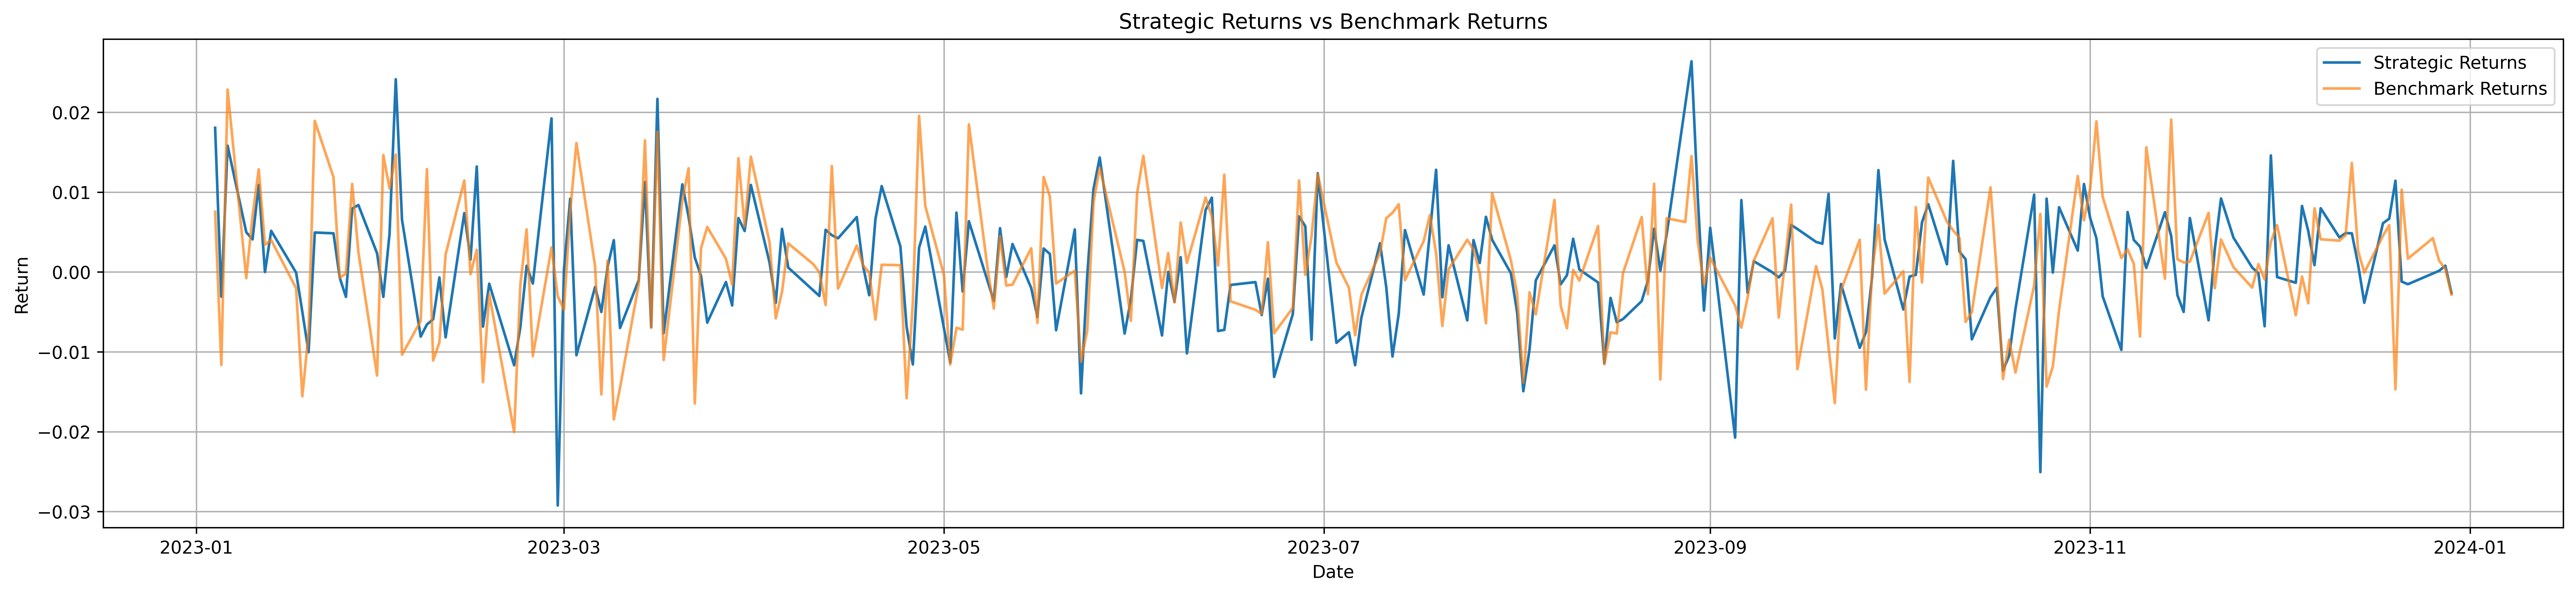

In [11]:
plt.figure(figsize=(25, 5), dpi=600)
plt.plot(portfolio_returns.index, portfolio_returns, label='Strategic Returns')
plt.plot(market_returns.index, market_returns, label='Benchmark Returns', alpha=0.7)
plt.title('Strategic Returns vs Benchmark Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

夏普比率（Sharpe Ratio）是衡量投资绩效的一个重要指标，它通过比较投资的超额收益（相对于无风险收益率）和投资的总风险（标准差）来计算。

夏普比率的计算公式如下：

$\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}$

其中：

- $R_p$ 是投资组合的预期收益率。
- $R_f$是无风险收益率。
- $\sigma_p$ 是投资组合的标准差（风险）。

夏普比率的解释：

- 如果夏普比率是正值，表示投资组合在扣除无风险收益后仍有正收益。
- 如果夏普比率是负值，表示投资组合的表现不如无风险投资。
- 一般来说，夏普比率越高，表示投资组合单位风险的收益越高，投资效率越好。


例如，如果有日收益率数据，夏普比率的计算方法如下：

$\text{Sharpe Ratio} = \frac{(平均日收益率 - 无风险日收益率) \times 252}{\text{日收益率标准差} \times \sqrt{252}}$

p.s. 252为一年交易日数量。无风险收益率使用 *美国联邦基金利率*。

In [12]:
def sharpe_ratio_calculator(portfolio_returns, annual_trading_days=252, risk_free_rate=0.0505):
    # 计算日收益率的平均值
    average_daily_return = portfolio_returns.mean()
    # 计算日收益率的标准差
    daily_std_dev = portfolio_returns.std()
    # 年化收益率
    annualized_return = (1 + average_daily_return) ** annual_trading_days - 1
    # 年化标准差
    annualized_std_dev = daily_std_dev * (annual_trading_days ** 0.5)
    # 计算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
    # print(sharpe_ratio)
    return sharpe_ratio
sharpe_ratio = sharpe_ratio_calculator(portfolio_returns)
print("投资策略的夏普比率: {:.4f}".format(sharpe_ratio))

投资策略的夏普比率: 1.1738


索提诺比率（Sortino Ratio）是一个类似于夏普比率的风险调整性能指标，但它只关注投资组合的下行风险，而不是总体波动性。索提诺比率通常用于评估投资组合在面对不利市场条件时的表现。

索提诺比率的计算公式：

$\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}$

其中：

- $R_p$ 是投资组合的预期收益率。
- $R_f$ 是无风险收益率。
- $\sigma_d$ 是投资组合下行波动性的标准差（仅考虑收益率低于平均水平的情况）。

In [13]:
def sortino_ratio_calculator(portfolio_returns, annual_return=0.06, risk_free_rate=0.0505):
    # 计算下行波动性
    # 首先计算投资组合日收益率低于平均值的收益率
    negative_returns = portfolio_returns[portfolio_returns < portfolio_returns.mean()]
    # 计算这些负收益率的标准差
    downside_std_dev = np.std(negative_returns)
    # 计算索提诺比率
    sortino_ratio = (annual_return - risk_free_rate) / downside_std_dev
    return sortino_ratio

sortino_ratio = sortino_ratio_calculator(portfolio_returns, annual_return=0.07)
print("投资策略的索提诺比率: {:.4f}".format(sortino_ratio))

投资策略的索提诺比率: 3.9335


In [14]:
# 计算每日累积收益
cumulative_returns = (1 + portfolio_returns).cumprod()

# 计算每个时间点的累积最大收益
cumulative_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_max - cumulative_returns

# 计算最大回撤
max_drawdown = drawdown.max()

# 找出最大回撤的时间范围
end_date = drawdown.idxmax()  # 最大回撤结束的时间
start_date = cumulative_returns[:end_date].idxmax()  # 最大回撤开始的时间

print("最大回撤: {:.2%}".format(max_drawdown))
print("最大回撤时间范围: {} 至 {}".format(start_date.date(), end_date.date()))

最大回撤: 11.77%
最大回撤时间范围: 2023-04-24 至 2023-08-22


In [15]:
# 计算累积收益
cumulative_returns_portfolio = (1 + portfolio_returns).cumprod()
cumulative_returns_market = (1 + market_returns).cumprod()

# 转化为百分比变化
cumulative_returns_portfolio_percent = (cumulative_returns_portfolio - 1) * 100
cumulative_returns_market_percent = (cumulative_returns_market - 1) * 100

# 计算超额收益
excess_returns = cumulative_returns_portfolio_percent - cumulative_returns_market_percent

# 确保没有 NaN 和异常值
excess_returns = excess_returns.replace([np.inf, -np.inf], np.nan).dropna()

# 计算每日累积超额收益
cumulative_excess_returns = (1 + excess_returns / 100).cumprod()

# 计算每个时间点的累积最大收益
cumulative_max = cumulative_excess_returns.cummax()

# 计算回撤
drawdown = cumulative_max - cumulative_excess_returns

# 计算最大回撤
max_drawdown = drawdown.max()

# 找出最大回撤的时间范围
end_date = drawdown.idxmax()
start_date = cumulative_excess_returns[:end_date].idxmax()


print("超额收益最大回撤: {:.2%}".format(max_drawdown))
print("超额收益最大回撤时间范围: {} 至 {}".format(start_date.date(), end_date.date()))

超额收益最大回撤: 1007.31%
超额收益最大回撤时间范围: 2023-06-07 至 2023-12-29


**信息比率计算公式**

$\text{Information Ratio} = \frac{R_p - R_b}{\sigma_{(R_p - R_b)}}$

其中：

- $\R_p$ 是投资组合的收益率。
- $\R_b$ 是基准的收益率。
- $\sigma_{(R_p - R_b)}$是超额收益的标准差，即投资组合收益率和基准收益率差异的标准差。


In [16]:
# 计算超额收益的标准差
excess_return_std_dev = excess_returns.std()

# 计算信息比率
information_ratio = excess_returns.mean() / excess_return_std_dev

print("信息比率: {:.4f}".format(information_ratio))


信息比率: -0.6285


In [19]:
# 计算特雷诺比率的函数
def calculate_treynor_ratio(returns, benchmark_returns, risk_free_rate=0.01):
    # alpha, beta = calculate_alpha_beta(returns, benchmark_returns, risk_free_rate)
    excess_returns = returns - risk_free_rate / 252
    return excess_returns.mean() / portfolio_beta

treynor_ratio = calculate_treynor_ratio(portfolio_returns, market_returns)
print("特雷诺比率: {:.4f}".format(treynor_ratio))

特雷诺比率: 0.0017


In [ ]:
# 计算年化收益率的函数
def calculate_annualized_return(cumulative_returns):
    n_years = len(cumulative_returns) / 252
    return (cumulative_returns[-1] / cumulative_returns[0]) ** (1 / n_years) - 1

annualized_return = calculate_annualized_return(cumulative_returns_portfolio)
print("年化收益率: {:.4%}".format(annualized_return))